As an introduction we'll look at a classification problem. 

The goal of classification is to predict a category out of a set of possible categories for an input. 

More specific, we are generating a probability distribution over the set of categories. 

As predicted category we take the category with the highest probability. 

The advantage of working with probability distributions is that is gives us a measure of confidence for the prediction.

The problem we are solving here is to classify grayscale images of handwritten digits (28x28 pixels) into 10 different categories (0 through 9). 

We’ll use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. 

It’s a set of 60,000 training images, plus 10,000 test images.

Here are some example images from MNIST:

<img src="images/mnist-1.jpg" height="450" width="600"/>

Note the different train and test datasets. 

We'll train the model on the train dataset and evaluate it on the test dataset. 

This separation is very important for a correct measurement of the model performance. 

We want to measure how well the model performs on data it has never seen before, this property is called **generalization**. 

At some point in the training process the model will overfit on the training data and as a result the performance on the test data will get worse.

Some ML terminology:

 * data points are called **examples**, usually denoted as $x$ for a single example or $X$ for multiple examples
 * a category in a classification problem is called a **class**
 * the class associated with a specific sample is called a **label**, usually denoted as $y$



### Load the MNIST dataset

In [1]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print('Train images:', train_images.shape)
print('Train labels:', train_labels.shape)
print('Test images:', test_images.shape)
print('Test labels:', test_labels.shape)

/Users/asprenger/anaconda3-5.1.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train images: (60000, 28, 28)
Train labels: (60000,)
Test images: (10000, 28, 28)
Test labels: (10000,)


### Plot some training examples

Label: 5


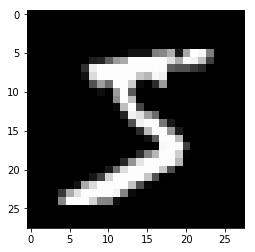

Label: 0


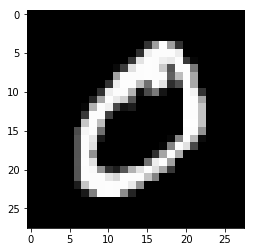

Label: 4


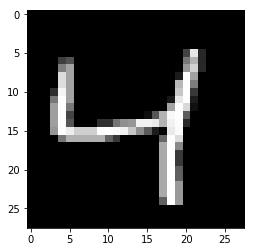

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(3):
    plt.imshow(train_images[i], cmap='gray')
    print('Label:', train_labels[i])
    plt.show()


`train_images` and `train_labels` form the training set, the data that the model will learn from. 

The model will then be tested on the test set, `test_images` and `test_labels`.

The images are encoded as Numpy arrays, and the labels are an array of digits, ranging from 0 to 9. 

The images and labels have a one-to-one correspondence.

The workflow will be as follows: 

 1. We’ll feed the neural network the training data, `train_images` and `train_labels`. 
 2. The network will then learn to associate images and labels. 
 3. We’ll ask the network to produce predictions for `test_images`, and we’ll verify whether these predictions match the labels from `test_labels`.

## Build the model

The core building block of neural networks is the **layer**. 

A layer is a function with some input and some output. 

Layers are often stacked on top of each other.

Here, our network consists of a sequence of two **dense layers**, also sometimes called fully connected layers.

A dense layer implements the following function: 

$$ 
output = activation(W \cdot input + b) 
$$

$input$ and $output$ are vectors.

$\cdot$ is the dot product.

$W$ is a matrix and $b$ is a vector, they are called the **parameters** of the layer. 

When you think about a layer as a stateful function than $W$ and $b$ would be the state.

The **activation function** computes the output of a layer. 

In most cases the activation function is a non-linear function. 

This model uses **Rectified Linear Unit (ReLU)** and **Softmax** activation functions.


In [3]:
from keras import models
from keras import layers

# define the model input
inputs = layers.Input((28 * 28,))

# define the first dense layer
x = layers.Dense(units=256, activation='relu')(inputs)

# define the output layer
output = layers.Dense(units=10, activation='softmax')(x)

# define a model that holds everything together
model = models.Model(inputs=inputs, outputs=output)

The last layer uses a softmax activation function, that returns a vector of 10 probability scores (summing to 1). 

Each score will be the probability that the input image belongs to one of our 10 digit classes.

The actual prediction will be the class with the highest probability.

In summary the model calculates the following function:

$$ 
probabilities = softmax(W_2 \cdot relu(W_1 \cdot input + b_1) + b_2)
$$

$W_1$, $b_1$, $W_2$ and $b_2$ are the parameters of the model.

Lets look at some details:

In [4]:
# print some details about each layer in the model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               200960    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


The model has about 200K parameters. In general this depends on the input size and the type and configuration of the individual layers. 

In our specific model, given that the input size and the number of classes is fixed, the number of parameters depends only on the `units` argument in the first dense layer.

A Keras model has the following primary methods:

 * `fit()`: this trains the model by 'fitting' the model parameters to the training data
 * `evaluate()`: measure the performance of the model by calculating evaluation metrics
 * `predict()`: predict labels for a set of examples


To be able to train the model we need three more things:

 * **loss function -** this measures the models prediction error, the difference between the prediction and the ground truth.
 * **optimizer -** an algorithm through which the model will update its parameters based on the training examples it sees and the loss calculated by the loss function
 * **other metrics -** in this case we only care about **accuracy**, the fraction of the images that were correctly classified
 
The model must be compiled to be ready for training.

In [5]:
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

## Preprocessing

Before we can start the training we need to preprocess the images. 

The model expects each train/test example as a vector, therefore we flatten the images. 

We also transform the image values to the range [0, 1], this helps the model to train faster.

In [6]:
print('Before preprocessing:')
print('Train images:', train_images.shape, train_images.dtype)
print('Test images:', test_images.shape, test_images.dtype)

train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

print('\n After preprocessing:')
print('Train images:', train_images.shape, train_images.dtype)
print('Test images:', test_images.shape, test_images.dtype)

Before preprocessing:
Train images: (60000, 28, 28) uint8
Test images: (10000, 28, 28) uint8

 After preprocessing:
Train images: (60000, 784) float32
Test images: (10000, 784) float32


We’re now ready to train the network. This is done by calling the models `fit()` method, it fits the model to its training data. 

`fit()` takes the following arguments:

 * train_images - the examples to train on
 * train_labels - the labels to calculate the loss
 * epochs - number of iterations over the training data
 * batch_size - number of examples to process in one step

## Train the model

In [7]:
h = model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
60000/60000 [==============================] - 2s 33us/step - loss: 0.2859 - acc: 0.9204
Epoch 2/5
60000/60000 [==============================] - 2s 32us/step - loss: 0.1267 - acc: 0.9630
Epoch 3/5
60000/60000 [==============================] - 2s 31us/step - loss: 0.0865 - acc: 0.9744
Epoch 4/5
60000/60000 [==============================] - 2s 30us/step - loss: 0.0648 - acc: 0.9814
Epoch 5/5
60000/60000 [==============================] - 2s 30us/step - loss: 0.0511 - acc: 0.9852


Two quantities are displayed during training: 
 * `loss`: the loss of the network over the training data
 * `acc`: the accuracy of the network over the training data
 
Now lets check how the model performs on the test data:

## Evaluate the model

In [8]:
_, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('Test accuracy:', test_acc)

Test accuracy: 0.9764


The accuracy is the percentage of correct predictions. 

The test accuracy is lower than the train accuracy. 

This is expected and called **overfitting** - during training the model learns aspects of the examples that are specific for the training data.

On a realworld problem it is usually not possible to train a model with perfect test accuracy. 

Having a test accuracy close to 1.0 usually means you have a bug in your preprocessing or training code and the model does not generalize.

## Plot a confusion matrix
The accuracy metric is the mean accuracy over all classes. 

The **confusion matix** is a tool to better understand the predictive performance of a model on individual classes. 

It breaks the evaluation result down and shows the correct and incorrect predictions for individual classes.

In [9]:
import numpy as np
import pandas as pd
probabilities = model.predict(test_images)
predictions = np.argmax(probabilities, axis=1)
confusion_matrix = pd.crosstab(test_labels, predictions, rownames=['True'], colnames=['Predicted'], margins=False)
print(confusion_matrix)


Predicted    0     1    2    3    4    5    6     7    8    9
True                                                         
0          968     0    1    0    1    1    3     1    3    2
1            0  1124    2    1    0    1    2     1    4    0
2            6     4  984    9    4    1    3     7   14    0
3            0     0    1  997    0    2    0     5    4    1
4            2     0    1    1  968    0    1     2    1    6
5            2     0    0   18    1  854    8     0    8    1
6            5     2    0    1    4    3  939     0    4    0
7            1     2    7    3    2    0    0  1004    3    6
8            2     1    3    5    3    2    2     2  951    3
9            2     2    0   11   10    2    0     5    2  975


The vertical axis represents the true labels and the horizontal axis represents the predicted labels. 

The values in the matrix are the counts how many times a true label has been predicted as one of the 10 classes. 

The main diagonal are the correct predictions, this is where a good model will have most of the counts.

In the example you can see that `4` and `9` are often confused with each other. 

`4` is predicted 13 times as `9` and `9` has been predicted 14 times as `4`. 

This makes sense because the two digits have a similar shape. 

On the other hand `0` and `1` are never confused with each other.

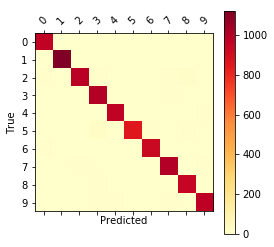

In [10]:
def plot_confusion_matrix(df_confusion, cmap=plt.cm.YlOrRd):
    plt.matshow(df_confusion, cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(confusion_matrix)

## Use the model for prediction

Generate predictions for the first 5 images of the test dataset.

label: 7 prediction: 7
[3.0040017e-08 9.5474129e-11 4.0560126e-06 7.5612312e-05 2.3169302e-11
 3.2741443e-08 5.6506102e-13 9.9991858e-01 5.7435955e-08 1.7805730e-06]


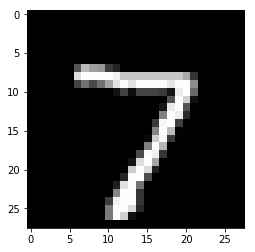

label: 2 prediction: 2
[5.1014726e-09 2.8676064e-05 9.9996006e-01 1.0259812e-05 1.9139552e-15
 2.1345245e-07 1.9217291e-07 3.3343768e-13 5.8520988e-07 8.0755972e-14]


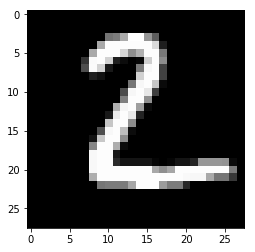

label: 1 prediction: 1
[1.3653940e-06 9.9902856e-01 7.7862758e-05 3.6850470e-05 2.8730094e-05
 1.1300601e-05 1.3686827e-05 6.3304423e-04 1.5715783e-04 1.1524101e-05]


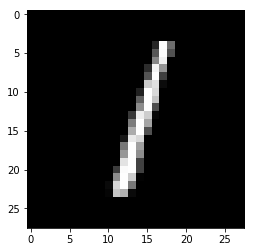

label: 0 prediction: 0
[9.9991250e-01 5.2648952e-10 5.1307561e-06 2.1024355e-06 9.6276801e-07
 5.5739260e-06 4.5836201e-05 1.5457088e-05 8.0884021e-08 1.2316074e-05]


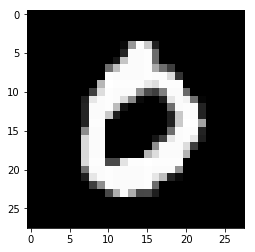

label: 4 prediction: 4
[5.2735013e-06 1.6090211e-09 5.0199219e-06 6.7867995e-06 9.7556031e-01
 3.3739786e-06 2.6290159e-06 8.5072062e-04 2.9131610e-05 2.3536699e-02]


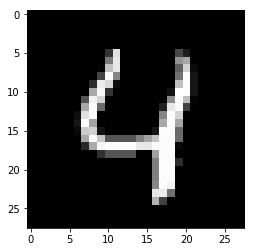

In [13]:
import numpy as np

probabilities = model.predict(test_images[0:5])
predicted_labels = np.argmax(probabilities, axis=1)

for i in range(predicted_labels.shape[0]):
    print('label:', test_labels[i], 'prediction:', predicted_labels[i])
    print(probabilities[i])
    plt.imshow(test_images[i].reshape(28,28), cmap='gray')
    plt.show()


## Plot some mispredictions

label: 9 prediction: 8
[[1.5918319e-03 8.6593825e-09 7.9352554e-05 7.0149757e-02 8.5713182e-06
  4.4983409e-02 1.0667838e-05 6.7786314e-05 4.5599207e-01 4.2711657e-01]]


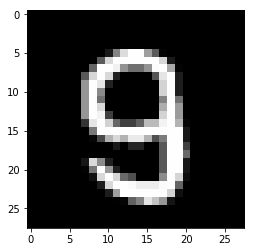

label: 4 prediction: 2
[[1.6446338e-06 4.1045056e-05 7.5113952e-01 1.1408926e-03 1.0467392e-01
  8.8838700e-05 1.4284348e-01 3.1981472e-05 3.8682902e-05 3.9106212e-08]]


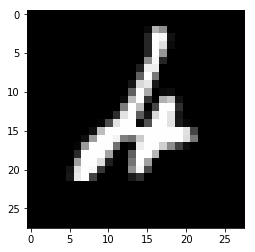

label: 6 prediction: 0
[[5.1555842e-01 2.7279028e-09 1.2719732e-06 1.1881103e-05 1.5068454e-04
  1.0856232e-03 4.8289511e-01 2.1294579e-04 8.3951483e-05 1.9759477e-07]]


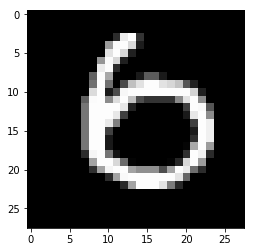

label: 9 prediction: 3
[[2.2975995e-07 1.3860975e-10 1.6652639e-05 5.9917474e-01 1.0918203e-07
  2.0827842e-06 1.5021172e-10 2.6055409e-03 8.2301791e-04 3.9737764e-01]]


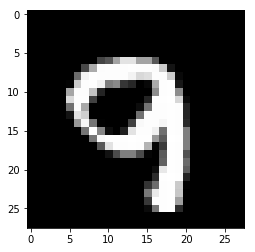

label: 9 prediction: 8
[[6.7597575e-06 1.5267602e-02 3.3416429e-03 2.0442424e-02 3.0835826e-04
  1.2452267e-04 2.0923203e-08 1.4003994e-01 4.8177242e-01 3.3869630e-01]]


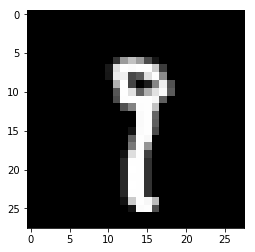

label: 2 prediction: 7
[[4.1838241e-05 5.5136017e-05 2.4039026e-02 1.8179039e-02 4.4104706e-10
  5.0152698e-06 3.6706163e-09 9.5054328e-01 7.0485752e-03 8.8131055e-05]]


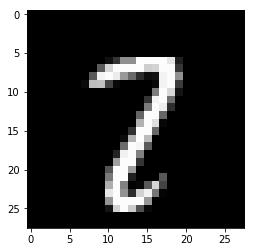

label: 5 prediction: 3
[[2.1261275e-07 4.1170903e-03 9.9909698e-07 9.1880655e-01 2.8810443e-06
  7.6775767e-02 1.1742812e-05 2.9173037e-07 1.4125949e-04 1.4314245e-04]]


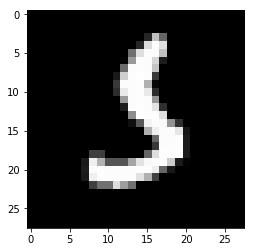

label: 3 prediction: 7
[[4.01811093e-07 6.02239516e-06 6.85646781e-04 1.25075085e-02
  1.33701249e-07 4.46435280e-07 1.52006940e-08 9.86791611e-01
  9.20393575e-07 7.29890826e-06]]


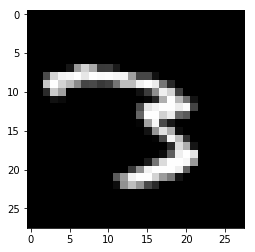

In [15]:
import numpy as np

for i in range(400):
    probabilities = model.predict(np.expand_dims(test_images[i], axis=0))
    predicted_labels = np.argmax(probabilities, axis=1)[0]
    true_label = test_labels[i]
    if predicted_labels != true_label:
        print('label:', true_label, 'prediction:', predicted_labels)
        print(probabilities)
        plt.imshow(test_images[i].reshape(28,28), cmap='gray')
        plt.show()



**Note::** There is dataset from Zalando called [fashion-mnist](https://github.com/zalandoresearch/fashion-mnist) that is a drop-in replacement for the original MNIST dataset but more challenging.